In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.api as sm
from scipy.optimize import minimize

params = {
    "axes.labelsize": 8, "font.size": 8, "legend.fontsize": 8,
    "xtick.labelsize": 8, "ytick.labelsize": 8, "text.usetex": False,
    "font.family": "sans-serif", "axes.spines.top": False, "axes.spines.right": False,
    "grid.color": "grey", "axes.grid": True,  "grid.alpha": 0.5, "grid.linestyle": ":",
}

plt.rcParams.update(params)

### Problem 4

In [2]:
x = np.array([-0.59,0.28,-1.08,0.79,-0.15,0.50,0.54,-1.05,0.66,0.40,0.31,-0.45,1.23,-1.71,0.43,-0.61,0.60,0.68,0.92,1.50])
y = np.array([0.694,0.408,1.33,0.266,0.111,0.382,0.165,2.766,0.103,0.309,0.009,0.032,0.057,1.53,0.152,0.358,0.214,0.375,0.193,0.245])

n = len(y)

In [3]:
def l(variables, y=y, x=x, n=n):
    alpha = variables[0]
    beta  = variables[1]
    
    term1 = -np.sum(y * np.exp(-alpha - beta*x))
    term2 = -n*alpha
    term3 = -np.sum(x)*beta
    return term1 + term2 + term3

minus_l = lambda x: -l(x)

In [4]:
x0 = [-1,-1]
res = minimize(minus_l, x0, method='BFGS', options={'gtol': 1e-6, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: -1.074270
         Iterations: 5
         Function evaluations: 24
         Gradient evaluations: 8
[-0.91523315 -0.86550233]


In [5]:
ngridx = 100
ngridy = 100
xi = np.linspace(-1.5, -0.1, ngridx)
yi = np.linspace(-1.5, -0.1, ngridy)
Xi, Yi = np.meshgrid(xi, yi)

In [6]:
Z = np.empty_like(Xi)

for i in range(Xi.shape[0]):
    for j in range(Xi.shape[1]):
        Z[i,j] = l([Xi[i,j], Yi[i,j]])

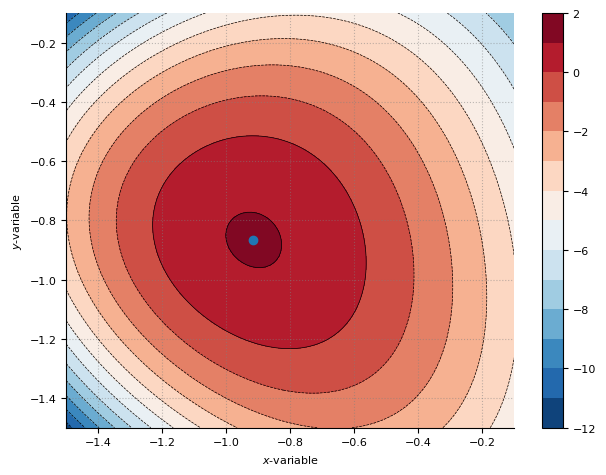

In [7]:
plt.contour(xi, yi, Z, levels=14, linewidths=0.5, colors='k')
cntr1 = plt.contourf(xi, yi, Z, levels=14, cmap="RdBu_r")
plt.colorbar(cntr1)
plt.scatter(res.x[0], res.x[1])
plt.xlabel(r'$x$-variable')
plt.ylabel(r'$y$-variable')
plt.tight_layout()
plt.savefig('figs_assignment3/contour.pdf')
plt.show()

In [8]:
def l_beta(beta, x=x, y=y, n=n):
    alpha = np.log((np.sum(y * np.exp(-beta * x)))/n)
    return l([alpha, beta])

In [9]:
beta_prof = np.empty_like(yi)

for idx, beta in enumerate(yi):
    beta_prof[idx] = l_beta(beta)

In [10]:
opt_value = res.fun
opt_beta = res.x[1]

In [11]:
np.sqrt(np.inner(x,x))

3.700081080192703

In [12]:
opt_beta

-0.8655023279716962

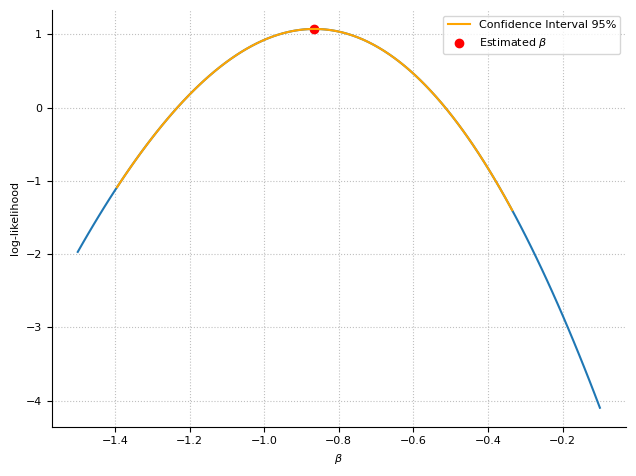

In [13]:
lower_beta = -0.865 - 1.96 * 1/3.7
upper_beta = -0.865 + 1.96 * 1/3.7

points_ci = np.linspace(lower_beta,upper_beta,1000)
l_values_ci = np.zeros_like(points_ci)
for idx, point in enumerate(points_ci):
    l_values_ci[idx] = l_beta(point)

plt.plot(yi, beta_prof)
plt.xlabel(r'$\beta$')
plt.ylabel('log-likelihood')
plt.plot(points_ci, l_values_ci, color='orange', alpha=1, label='Confidence Interval 95%')
plt.scatter(opt_beta, -opt_value, color='red', label=r'Estimated $\beta$')
plt.legend()
plt.tight_layout()
plt.savefig('figs_assignment3/profile_beta.pdf')
plt.show()

In [14]:
print(lower_beta)
print(upper_beta)

-1.3947297297297296
-0.33527027027027034


### Problem 5

In [42]:
m = 20
n = 1000
shape = [m]
mu = 5
sigma = 1

# np.random.seed(0)
# sample = np.random.normal(loc=mu, scale=sigma, size=shape)

sample = pd.read_csv('random_sample.csv').values.reshape(-1)

theta = np.exp(mu)

pivot_func = lambda x: np.sqrt(x.shape[0]) * (np.exp(np.mean(x)) - theta)

pivots_non_parametric = np.zeros(n)

for i in range(n):
    idxs = np.random.randint(low=0, high=m-1, size=shape)
    bs_sample = sample[idxs]
    
    pivots_non_parametric[i] = pivot_func(bs_sample)
    
pivots_parametric = np.zeros(n)
mu_hat = np.mean(sample)

for i in range(n):
    subsample = np.random.normal(loc=mu_hat, scale=sigma, size=shape)
    
    pivots_parametric[i] = pivot_func(subsample)
    
## Delta method

se_theta_hat = np.exp(mu_hat) / np.sqrt(m)
theta_hat = np.exp(mu_hat)

/tmp/ipykernel_80374/2003006216.py:12: RuntimeWarning: invalid value encountered in log
  z_cons = lambda x: np.sqrt(m) * np.log(x/np.exp(mu)/np.sqrt(m) + 1)


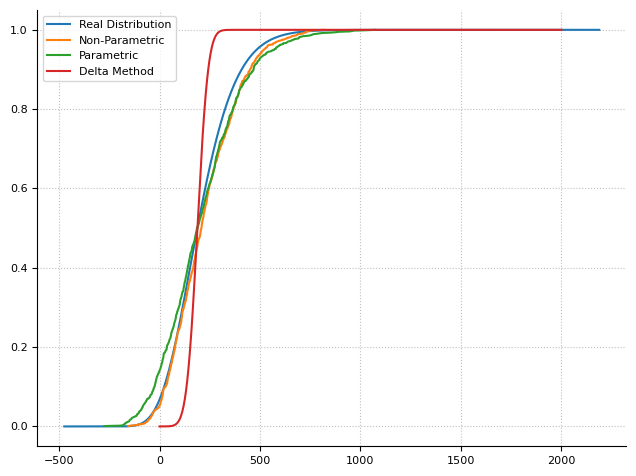

In [43]:
Phi = lambda x: stats.norm().cdf(x)

## Plot cdfs

c_1 = 0.001
c_2 = 0.999

## True Distribution

t = np.linspace(-2000, 2000, 1000)

z_cons = lambda x: np.sqrt(m) * np.log(x/np.exp(mu)/np.sqrt(m) + 1)

plt.plot(t + np.exp(mu_hat), Phi(z_cons(t)), label='Real Distribution')

## b pivot

ecdf_b = stats.ecdf(pivots_non_parametric)
plt.plot(ecdf_b.cdf.quantiles, ecdf_b.cdf.probabilities, label='Non-Parametric')

## c pivot

ecdf_c = stats.ecdf(pivots_parametric)
plt.plot(ecdf_c.cdf.quantiles, ecdf_c.cdf.probabilities, label='Parametric')

xs = np.linspace(0,2000, 1000)
cdf_d = stats.norm(loc=theta_hat,scale=se_theta_hat).cdf(xs)
plt.plot(xs, cdf_d, label='Delta Method')


plt.legend()
plt.tight_layout()
plt.savefig('figs_assignment3/cdfs.pdf')
plt.show()